In [36]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from random import randint
from scipy.optimize import curve_fit
from scipy.stats import poisson
import random

In [37]:
def get_all_files(filename,ending='.root'):
    dir_path = './'

    index=[i+1 for i in range(len(filename)) if  filename[i]=='/']
    if len(index)>0:
        dir_path=filename[:index[-1]]
        filename=filename[index[-1]:]

    res = []
    filelist=os.listdir(dir_path)
    filelist.sort()
    for file in filelist:
        if file.startswith(filename) and file.endswith(ending):
            res.append(f'{dir_path}{file}')
    return res

In [38]:
def df_to_list(xtmp):
    x = []
    for i in range(len(xtmp)):
        str=xtmp[i][1:-1]
        try:
            str.index(',')
            sep=','
        except ValueError:
            sep=' '
        
        tmp=np.fromstring(str, dtype=float, sep=sep)
        x.append(tmp)
    return x


In [39]:
def draw_subplots(xlabel,ylim,yscale='linear',draw_lines='none',ylabel='', radius=[0,100,125,150,175,200,225,250,265]):
    # capture radius for all events
    nrows=int(np.ceil(len(radius)/3))
    ncol=3
    if len(radius)<4:
        ncol=len(radius)
    fig, axss = plt.subplots(nrows, ncol, figsize=(ncol*4,nrows*4),sharex=True)
    axs=axss.reshape(nrows,ncol)
    for i in range(len(radius)):
        idx1=int(i/3)
        idx2=i%3
        if draw_lines=='lines':
            axs[idx1][idx2].axvline(x=0.95,color='lightgray',linestyle='dotted')
            axs[idx1][idx2].axvline(x=2.75,color='lightgray',linestyle='dotted')
            axs[idx1][idx2].axvline(x=3.25,color='lightgray',linestyle='dotted')
            if radius[i] > 0:
                axs[idx1][idx2].axvline(x=radius[i]/100.,color='lightgray',linestyle='dotted')
        if draw_lines=='radius':
            theta = np.arange(0, np.pi * 2, 0.01)
            axs[idx1][idx2].plot(0.95 * np.cos(theta), 0.95 * np.sin(theta),color='black')
            axs[idx1][idx2].plot(2.75 * np.cos(theta), 2.75 * np.sin(theta),color='black')
            axs[idx1][idx2].plot(3.25 * np.cos(theta), 3.25* np.sin(theta),color='black')
            axs[idx1][idx2].plot(5.5 * np.cos(theta), 5.5* np.sin(theta),color='black')
            if radius[i] > 0:
                axs[idx1][idx2].plot(radius[i]/100. * np.cos(theta), radius[i]/100. * np.sin(theta),color='black')
                axs[idx1][idx2].plot((radius[i]/100.+0.1) * np.cos(theta), (radius[i]/100.+0.1) * np.sin(theta),color='black')
        if draw_lines=='rectangle':
            axs[idx1][idx2].set_xlim(-7,7)
            axs[idx1][idx2].set_ylim(-8,5)
            rcryo_inner = plt.Rectangle((-2.75,-3.75), 5.5, 5.5,ec="black",facecolor='none')
            rcryo = plt.Rectangle((-3.25,-4.25), 6.5, 6.5,ec="black",facecolor='none')
            rwater_tank = plt.Rectangle((-5.5,-7.5), 11, 13,ec="black",facecolor='none')
            axs[idx1][idx2].add_patch(rwater_tank)
            axs[idx1][idx2].add_patch(rcryo)
            axs[idx1][idx2].add_patch(rcryo_inner)
            axs[idx1][idx2].set_ylim(-8,6)
            axs[idx1][idx2].set_xlim(-6,6)
        axs[idx1][idx2].set_title(f'r={radius[i]}cm')
        axs[idx1][idx2].set_ylim(ylim[0],ylim[1])
        axs[idx1][idx2].set_yscale(yscale)
        axs[idx1][idx2].set_ylabel(ylabel)
        if idx1==nrows-1:
            axs[idx1][idx2].set_xlabel(xlabel)
        if idx2==0:
            axs[idx1][idx2].set_ylabel(ylabel)
    return [fig,axs]

In [40]:
def read_csv(filenames,ending='.csv'):
    files=get_all_files(filenames,ending)
    nCA = []
    nCZ = []
    cross_cryo = []
    print(f"Reading in data... ({files})")
    #df_in = []
    for file in tqdm(files):
        df_in = pd.read_csv(file,skiprows=1)
    #    print(df_in)
        df_in.to_numpy()

        nCA.extend(df_in['nC_A'].to_numpy())
        nCZ.extend(df_in['nC_Z'].to_numpy())
        cross_cryo.extend(df_in['cross_cryo'].to_numpy())
    return [nCA,nCZ,cross_cryo]

In [41]:
def read_design_parameters(filenames,ending='.csv'):
    files=get_all_files(filenames,ending)
    params = []
    for idx,file in enumerate(files):
        with open(file) as f:
            first_line = f.readline()
            first_line=first_line[first_line.find('[')+1:first_line.find(']')]
            x = [k for k in first_line.split(",")]
            if idx==0:
                params=x
            elif idx > 0 and params!=x:
                print(f"Error {files[idx-1]} and {files[idx]} don't have the same parameters")
    return params

In [42]:

nSamples=2
version = 'v2'
if not os.path.exists(f'out/{version}'):
   os.makedirs(f'out/{version}')
nCA = []
nCZ = []
iidx = []
nprimaries = []
cross_cryo = []
nLF=0
sim_mode = []
radius = []
design = []
thickness = []
theta = []
phi = []
npanels = []
Length = []
zpos = []
volume = []
height = []
nHF=0

for m in range(0,nSamples):
    #filename=f'../simulation/out/LF/{version}/scans_5dim/neutron-sim-D4-LF-{m}_'
    filename=f'../simulation/out/HF/{version}/Neutron-Simulation-D4-New-Samples/neutron-sim-D4-LF-n{m}_'
    tmp=np.array(read_design_parameters(filename))
    sim_mode.append(tmp[0])
    design.append(float(tmp[1]))
    radius.append(float(tmp[2]))
    height.append(float(tmp[8]))
    thickness.append(float(tmp[3]))
    volume.append(float(tmp[10]))
    Length.append(float(tmp[7]))
    theta.append(float(tmp[6]))
    zpos.append(float(tmp[9]))
    npanels.append(float(tmp[4]))
    phi.append(float(tmp[5])/np.pi*180.)
    [nCA000,nCZ000,cross_cryo000] = read_csv(filename)
    nprimaries.append(25000*len(get_all_files(filename,ending='.csv')))
    iidx.append(len(nCA))
    nCA.extend(nCA000)
    nCZ.extend(nCZ000)
    cross_cryo.extend(cross_cryo000)
    nLF+=1


Error ../simulation/out/HF/v2/Neutron-Simulation-D4-New-Samples/neutron-sim-D4-LF-n0_0000.csv and ../simulation/out/HF/v2/Neutron-Simulation-D4-New-Samples/neutron-sim-D4-LF-n0_0001.csv don't have the same parameters
Reading in data... (['../simulation/out/HF/v2/Neutron-Simulation-D4-New-Samples/neutron-sim-D4-LF-n0_0000.csv', '../simulation/out/HF/v2/Neutron-Simulation-D4-New-Samples/neutron-sim-D4-LF-n0_0001.csv'])


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


Reading in data... (['../simulation/out/HF/v2/Neutron-Simulation-D4-New-Samples/neutron-sim-D4-LF-n1_0000.csv', '../simulation/out/HF/v2/Neutron-Simulation-D4-New-Samples/neutron-sim-D4-LF-n1_0001.csv'])


100%|██████████| 2/2 [00:00<00:00,  6.72it/s]


In [43]:
iidx.append(len(nCA))

GERDA muon rate: $(3.47 \pm 0.07) \cdot 10^{-4}/(m^2 \cdot \rm s)$ <br>
LEGEND with 13 m diameter of water tank: <br>
muon rae 46.058 mHz <br>
= 3979.411 per day <br>
= 1452485.088 per year <br>
LEGEND with 5.5 m diameter of LAr cryo: <br>
muon rae 46.058 mHz <br>
= 259985.121 per year <br>
number of neutrons per muon: ~13 % <br>
1000 kg Ge

In [44]:
Ge77factor=0.13/1000*(np.pi*6.5**2)/3.171e-8*3.47*1e-4
Ge77factor_err=0.13/1000*(np.pi*6.5**2)/3.171e-8*0.07*1e-4
cryo_area=(np.pi*2.75**2)
water_area=(np.pi*6.5**2)
muon_rate_per_yr_per_m2=3.47*1e-4/3.171e-8
muon_rate_per_yr=muon_rate_per_yr_per_m2*cryo_area
muon_rate_per_yr_err=0.07*1e-4/3.171e-8*cryo_area

In [45]:
Ge_mass=1000
Ge77factor=muon_rate_per_yr/Ge_mass
Ge77factor_err=muon_rate_per_yr_err/Ge_mass
Ge77LFscaling=1494984/10100000
Ge77LFscaling_err=np.sqrt(1494984)/10100000
Ge77HFscaling=1

def fNPrimariesLF(scaling, n_neutrons):
    return n_neutrons/scaling
def fGe77Rate(nCZ,Ge77factor,nprimaries):
    return nCZ*(Ge77factor/nprimaries)

In [46]:
def monte_carlo_simulations(rate_mean, rate_std, n_iter=10000):
    outputs = []
    for i in range(n_iter):
        result = random.normalvariate(rate_mean, rate_std)
        outputs.append(result)
    return outputs

def gauss(x, A, mean, sigma):
    return A * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

def Ge77MonteCarlosSim(nevt,Ge77factor,nprimaries):
    nevt_std=np.sqrt(nevt)
    events = monte_carlo_simulations(nevt,nevt_std)
    results = [fGe77Rate(k,Ge77factor,nprimaries) for k in events]
    values, bins = np.histogram(results, bins=100)    
    x = (bins[:-1] + bins[1:]) / 2
    #plt.scatter(x,values)
    parameters, covariance = curve_fit(gauss, x, values, p0 = [250, fGe77Rate(nevt,Ge77factor,nprimaries), fGe77Rate(nevt_std,Ge77factor,nprimaries)])
    #plt.plot(x,gauss(x,parameters[0],parameters[1],parameters[2]))
    return parameters[2]

In [47]:
Ge77 = []
Ge77err = []
Ge77Rate_err = []
Ge77Rate = []
Ge77Rate1 = []
n_neutrons = []
Ge77Eff_err = []
Ge77Eff = []
Ge77Rate_err_stat = []

for j in range(len(iidx)-1):
    itmp=int(j/3)
    iitmp=int(j%3)
    length=iidx[j+1]-iidx[j]

    #nCZtmp2=[nCZ[i] for i in range(iidx[j],iidx[j+1],1) if nCZ[i]==32 and nCA[i]==77]
    nCGe77=len([nCZ[i] for i in range(iidx[j],iidx[j+1],1) if nCZ[i]==32 and nCA[i]==77 and cross_cryo[i]!=-1])
    nneutrons=len([cross_cryo[i] for i in range(iidx[j],iidx[j+1],1) if cross_cryo[i]!=-1])
    GeEvents = []

    if j < nLF:
        n_neutrons.append(length)
        nprims=length/Ge77LFscaling

        err_x3=nCGe77*(Ge77factor*Ge77LFscaling/(n_neutrons[j]**2))*np.sqrt(n_neutrons[j])
        err_x4=nCGe77*(Ge77factor*Ge77LFscaling_err/n_neutrons[j])
        

    else:
        n_neutrons.append(nneutrons)
        nprims=nprimaries[j]
        err_x3=nCGe77*(Ge77factor/(nprims**2))*np.sqrt(nprims)
        err_x4=0

    err_x1=np.sqrt(nCGe77)*(Ge77factor/nprims)
    err_x2=nCGe77*(Ge77factor_err/nprims)
    
    err_xx1=np.sqrt(nCGe77)/nneutrons
    err_xx2=nCGe77/nneutrons**2*np.sqrt(nneutrons)

    Ge77Rate_err_stat.append(Ge77MonteCarlosSim(nCGe77,Ge77factor,nprims))

    Ge77.append(nCGe77)
    Ge77err.append(np.sqrt(nCGe77))
    Ge77Rate.append(fGe77Rate(nCGe77,Ge77factor,nprims))
    Ge77Rate_err.append(np.sqrt(err_x1**2+err_x2**2+err_x3**2+err_x4**2))
    Ge77Eff.append(Ge77[j]/nneutrons)
    Ge77Eff_err.append(np.sqrt(err_xx1**2+err_xx2**2))



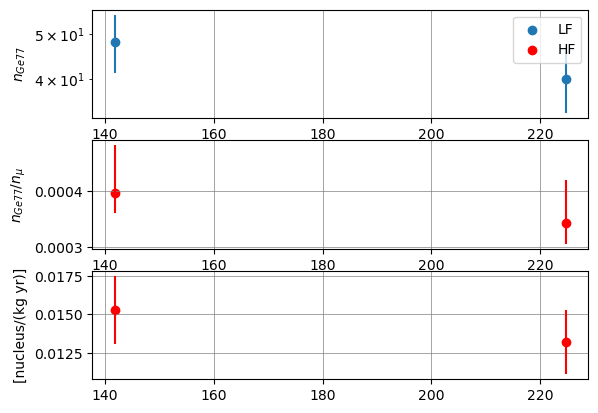

In [48]:
fig, (ax1,ax2,ax3)= plt.subplots(3,1)
ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax1.errorbar(radius[0:nLF],np.array(np.array(Ge77))[0:nLF],np.array(np.sqrt(np.array(Ge77)))[0:nLF],ls='none')
ax1.scatter(radius[0:nLF],np.array(np.array(Ge77))[0:nLF],label='LF')
ax1.errorbar(radius[nLF:],np.array(np.array(Ge77))[nLF:],np.array(np.sqrt(np.array(Ge77)))[nLF:],ls='none',color='red')
ax1.scatter(radius[nLF:],np.array(np.array(Ge77))[nLF:],color='red',label='HF')
ax1.set_ylabel('$n_{Ge77}$')
ax1.set_yscale('log')
ax1.legend(loc='upper right')

ax2.grid(color='gray', linestyle='-', linewidth=0.5)
ax2.errorbar(radius[0:-nHF],Ge77Eff[0:-nHF],Ge77Eff_err[0:-nHF],ls='none')
ax2.scatter(radius[0:-nHF],np.array(np.array(Ge77)/np.array(n_neutrons))[0:-nHF],label='LF')
ax2.errorbar(radius[-nHF:],Ge77Eff[-nHF:],Ge77Eff_err[-nHF:],ls='none',color='red')
ax2.scatter(radius[-nHF:],np.array(np.array(Ge77)/np.array(n_neutrons))[-nHF:],color='red',label='HF')
ax2.set_ylabel('$n_{Ge77}/n_\mu$')


ax3.grid(color='gray', linestyle='-', linewidth=0.5)
ax3.scatter(radius[0:-nHF],Ge77Rate[0:-nHF],label='LF')
ax3.errorbar(radius[0:-nHF],Ge77Rate[0:-nHF],Ge77Rate_err[0:-nHF],ls='none')

ax3.errorbar(radius[-nHF:],Ge77Rate[-nHF:],Ge77Rate_err[-nHF:],ls='none',color='red')
ax3.scatter(radius[-nHF:],Ge77Rate[-nHF:],color='red',label='HF')
ax3.set_ylabel('[nucleus/(kg yr)]')
fig.savefig(f'out/{version}/neutron-Ge77-capture-new-samples_{version}.png')

In [49]:
#np.set_printoptions(threshold=sys.maxsize)
df = pd.DataFrame({'Mode': sim_mode, 'Design': design, 'Radius[cm]': radius, 'Thickness[cm]': thickness, 'NPanels': npanels, 'Phi[deg]': phi, 'Theta[deg]': theta, 'Length[cm]':Length, 'Height[cm]': height, 'ZPosition[cm]':zpos, 'Volume[cm3]':volume, 'Ge-77[nevents]':Ge77, 'Ge-77_err[nevents]':np.sqrt(np.array(Ge77)), 'Ge77-Eff': Ge77Eff, 'Ge77-Eff_err': Ge77Eff_err, 'Ge77-Rate[nucleus/(kg yr)]': Ge77Rate, 'Ge77-Rate_err[nucleus/(kg yr)]': Ge77Rate_err, 'Ge77-Rate_err_stat[nucleus/(kg yr)]': Ge77Rate_err_stat, 'nprimaries':nprimaries, 'total_neutrons': n_neutrons})
df

,Mode,Design,Radius[cm],Thickness[cm],NPanels,Phi[deg],Theta[deg],Length[cm],Height[cm],ZPosition[cm],Volume[cm3],Ge-77[nevents],Ge-77_err[nevents],Ge77-Eff,Ge77-Eff_err,Ge77-Rate[nucleus/(kg yr)],Ge77-Rate_err[nucleus/(kg yr)],Ge77-Rate_err_stat[nucleus/(kg yr)],nprimaries,total_neutrons
0,LF,4.0,224.7,19.0,145.0,142.251591,17.0,14.7,300.0,42.0,19239522.12,40,6.324555,0.000363,0.000057,0.013195,0.002104,0.002117,50000,116660
1,LF,4.0,141.8,4.4,289.0,71.371905,33.2,62.2,300.0,42.0,24318974.10,48,6.928203,0.000422,0.000061,0.015293,0.002229,0.002227,50000,120785


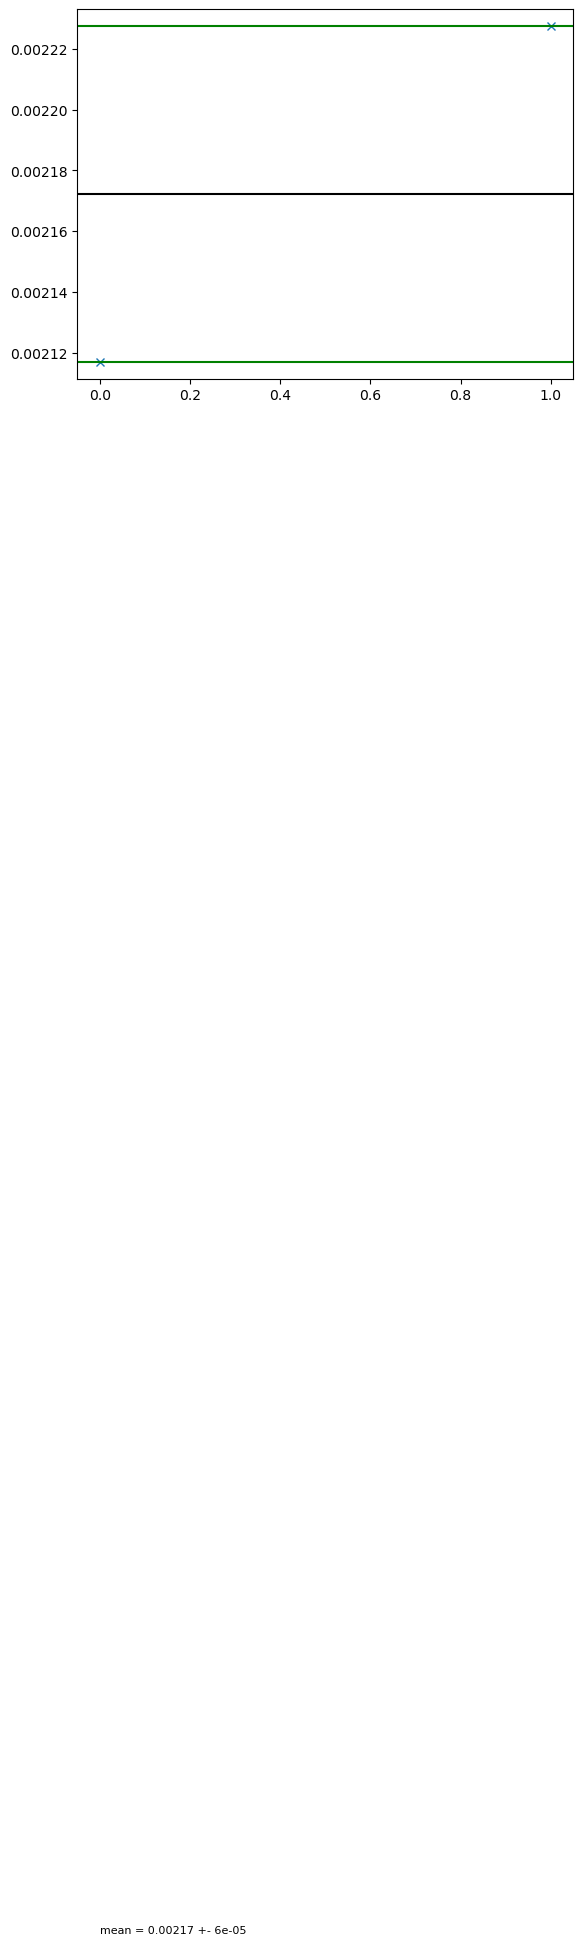

In [50]:

values, bins = np.histogram(Ge77Rate_err_stat[0:nLF], bins=10)    
x = (bins[:-1] + bins[1:]) / 2
#plt.scatter(x,values)
plt.plot(Ge77Rate_err_stat[0:nLF],"x")
# only one line may be specified; full height
plt.axhline(y = np.mean(Ge77Rate_err_stat[0:nLF]), color = 'black')
plt.axhline(y = np.mean(Ge77Rate_err_stat[0:nLF])-np.std(Ge77Rate_err_stat[0:nLF]), color = 'green')
plt.axhline(y = np.mean(Ge77Rate_err_stat[0:nLF])+np.std(Ge77Rate_err_stat[0:nLF]), color = 'green')
plt.text(0,0.0016,f"mean = {np.round(np.mean(Ge77Rate_err_stat[0:nLF]),5)} +- {np.round(np.std(Ge77Rate_err_stat[0:nLF]),5)}",fontsize=8)
plt.savefig(f"out/{version}/noise_LF_new_samples_{version}.png")

In [51]:
f=open(f'out/{version}/Ge77_rates_new_samples_{version}.csv',"w")
f.write(f"# LF noise: mean = {np.mean(Ge77Rate_err_stat[0:nLF])} +- {np.std(Ge77Rate_err_stat[0:nLF])}"+"\n")
f.close()
df.to_csv(f'out/{version}/Ge77_rates_new_samples_{version}.csv',mode='a')

In [53]:
(0.015293*0.8285+0.015293*0.9969)/2

0.0139579211